# Baseline Rhythmic Assessment System

Throughout this notebook we are going to ilustrate the utility of our MAST Rhythmic subset for assessment tasks by creating a simple rhythmic assessment system which uses the previously calculated onset data to predict quantitative assessments (i.e. grades) for rhythmic performances.

It requires that you have went through the _PreProcessDataFromMASTDataset.ipynb_ notebook.

Starting by importing necessary modules and creating some auxiliar functions to handle the data previously stored in the pre-processing phase.

In [13]:
import os
import numpy as np
import pip

from sklearn.datasets.base import *
from textdistance import *
from scipy.spatial.distance import *

DATA_FOLDER = "../data/"

       
### storage handlers ###
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
def get_info(index, performance_type, info_file_format):   
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]
    

audio_file = '53_rhy1_ref187859.wav'
idx = get_audio_index(audio_file, 'reference')

print('Onset bins for %s:' % audio_file, get_info(idx, 'reference', 'MAST Onsets [{}s] [BINS]'))

Onset bins for 53_rhy1_ref187859.wav: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


Now we define two extra functions designed to enrich the feature model with information regarding difference of beats between reference and performance and a normalized rhythmic Mean-Squared-Error originally proposed by Percival in http://percival-music.ca/research/masters-percival.pdf. The other distances comprised by the feature model are the [Levenshtein (aka Edit Distance)](https://en.wikipedia.org/wiki/Levenshtein_distance), [Damerau Levenshtein](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance), [Jaro](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance#Jaro_Similarity), [Jaro Winkler](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance), [Hamming](https://en.wikipedia.org/wiki/Hamming_distance), [Yule](https://reference.wolfram.com/language/ref/YuleDissimilarity.html) and [Matching](https://en.wikipedia.org/wiki/Matching_distance).

The last function is responsible for deriving the targets (dependent variables) of our models according to the grades provided by the annotators. Two targets are considered: a continuous target regarding the average grade provided by the annotators and a binary target meaning whether or a performance was accepted. In this scenario a performance is successful if the average of its grade is greater or equal than 3.

In [20]:
def beat_difference(v1, v2):
    return abs(v1.count(1) - v2.count(1))

def mean_squared_error_for_rhythm(A_bin, E_bin, Km = 25 , Ks = 0.55):
    '''
    Implementation of a MSE function designed
    for rhythmic assessment purposes. The original
    algorithm is proposed by Percival in
    http://percival-music.ca/research/masters-percival.pdf
    '''
    def closest_value(alist, value):
        min_diff = float('inf')
        c_value = None
        
        for element in alist:
            if abs(value - element) < min_diff:
                min_diff = abs(value - element)
                c_value = element
        
        return c_value
                
        
    A = [i for i in range(len(A_bin)) if A_bin[i]]
    E = [i for i in range(len(E_bin)) if E_bin[i]]
    
    mse = 0
    
    for i in range(len(E)):
        c_val = closest_value(A, E[i])
        error = abs(c_val - E[i])
        error = np.power(error,2)/len(E)
        error = min(error, Km)
        mse+=error
    
    for i in range(len(A)):
        c_val = closest_value(E, A[i])
        error = abs(c_val - A[i])
        error = np.power(error,2)/len(A)
        error = min(error, Km)
        mse+=error
    
    return 100 - Ks * mse


def get_class_for_performance(audio_name, multiclass=True):
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                            
    # the average grade across all annotations is calculated according to the following:
    # "leave the max and min value out and compute an average of the rest"
    annotations.remove(max(annotations))
    annotations.remove(min(annotations))
    average_grade = sum(annotations)/len(annotations)
    if multiclass:
        return (average_grade, np.std(annotations))
    # the binary class of a performance is 1 (accepted) if mode is 3 or higher. 0 (rejected) otherwise
    return 1 if average_grade >= 3 else 0

print(get_class_for_performance('55_rhy1_per121260_pass.wav'))
print(get_class_for_performance('55_rhy1_per121260_pass.wav', multiclass=False))


print(get_class_for_performance('52_rhy1_per157160_fail.wav'))
print(get_class_for_performance('52_rhy1_per157160_fail.wav', multiclass=False))

(3.8, 0.39999999999999997)
1
(1.8, 0.40000000000000002)
0


Finally, we join features and targets into a single dataset that will feed the Machine Learning models.

In [34]:
def load_rhythmic_performances():
    features = []
    target_multiclass = []
    target_binary = []
    
    DISTANCE_FUNCTIONS = [beat_difference, mean_squared_error_for_rhythm, #rhythm-based features
                          levenshtein, damerau_levenshtein, jaro, jaro_winkler, # text-based features
                          hamming, yule, matching] # vector-based features
    
    with open('../data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('../data/Only Performances/listperformances', 'r') as performances_file,\
         open('../data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('../data/Only References/listreferences', 'r') as references_file,\
         open('../data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')   
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            target_multiclass.append(get_class_for_performance(performance))
            target_binary.append(get_class_for_performance(performance, multiclass=False))
            
    return Bunch(data=np.asarray(features), target_multiclass=np.asarray(target_multiclass), target_binary=np.asarray(target_binary)) 

# loading rhythmic dataset
mast = load_rhythmic_performances()

The first analysis we can provide with this new data is to check the consistency of the grades provided by the annotators. For such, we plot the distribution of grades as well as the deviation across all anotators.

################ Consistency of Annotations ################

Average of standard deviations: 0.493443123979
Max standard deviation: 0.979795897113
Performances with no standard deviation: 38



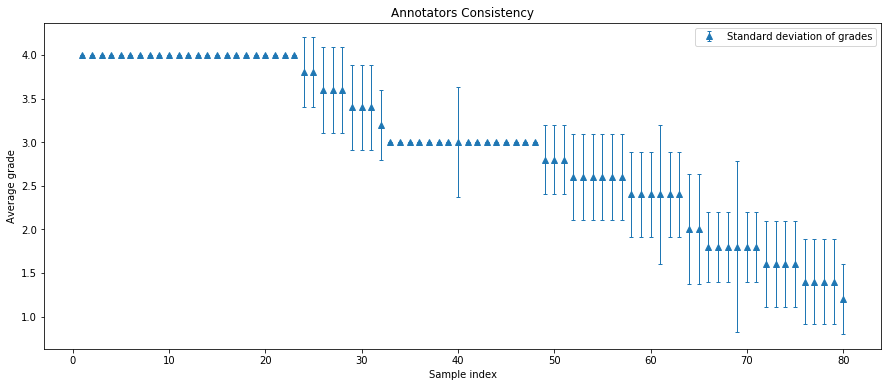

In [36]:
# loading model data
X, y_binary, y_multiclass = mast.data, mast.target_binary, mast.target_multiclass

x = np.arange(1, len(mast.target_multiclass) + 1) # for plotting purposes

binary_target = [y_m[i][0] for i in range(len(y_m))]
stdev = np.array([y_m[i][1] for i in range(len(y_m))])

non_zero_stdevs = [x for x in e if x > 0]
print("################ Consistency of Annotations ################")
print()
print("Average of standard deviations:", sum(non_zero_stdevs)/len(non_zero_stdevs))
print("Max standard deviation:", max(non_zero_stdevs))
print("Performances with no standard deviation:", len(e) - np.count_nonzero(e))
print()

plt.figure(figsize=(15,6))
plt.title("Annotators Consistency")
plt.ylabel("Average grade")
plt.xlabel("Sample index")
error_bar = plt.errorbar(x, binary_target, stdev, marker='^', capsize=2, elinewidth=1, markeredgewidth=1,label="Standard deviation of grades", ls='none')
plt.legend()

plt.show()

In order to allow for the creation of Machine Learning models and measurement of their respectives performances, we import the necessary modules and create a learning curve plotting function.

In [27]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs)  
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

The first model to be evaluated is a Logistic Regression classifier used to predict fail/pass judgments. The classifier is trained with the the binary target and is ran multiple times with different training set configurations using a 5-fold cross validation. The learning curve for such model is then presented. Maximum accuracy obtained is 0.75(?).

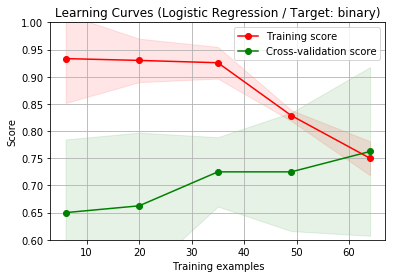

In [30]:
# setting up a 5-fold cross validation for estimators
cv = KFold(n_splits=5, shuffle=True, random_state=0)
title = r"Learning Curves (Logistic Regression / Target: binary)"

logit_reg_estimator = LogisticRegression()

plot_learning_curve(logit_reg_estimator, title, X, y_binary, (.6, 1), cv=cv)

plt.show()

Finally, our second model presents us a Linear Regression estimator for fractional grades. After training the model using the same aforementioned cross validation mechanism, we achieve the mean absolute errors listed below. Comparisons are made with dumb estimators.

In [33]:
linear_reg_estimator = LinearRegression()
linear_reg_estimator.fit(X, mast.target_multiclass[:,0])
# fitting dumb model which assigns 2, 3 and random values to all performances to be estimated
base_random_grades = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]

mean_absolute_errors_random = []
mean_absolute_errors_only_twos = []
mean_absolute_errors_only_threes = []

for train_index, test_index in cv.split(X):
    y_test = mast.target_multiclass[:,0][test_index]
    
    np.random.shuffle(base_random_grades)
    mean_absolute_errors_random.append(mean_absolute_error(y_test, base_random_grades)) 
    
    predictions_all_two = np.repeat(2, len(y_test))
    mean_absolute_errors_only_twos.append(mean_absolute_error(y_test, predictions_all_two))
    
    predictions_all_three = np.repeat(3, len(y_test))    
    mean_absolute_errors_only_threes.append(mean_absolute_error(y_test, predictions_all_three)) 
    
# running cross validation over our dataset
cross_val_errors = cross_val_score(linear_reg_estimator, X, mast.target_multiclass[:,0], scoring='neg_mean_absolute_error', cv=cv)

print("################ Linear Regression Model for grade estimation ################")
print()
print("Mean absolute error: Dumb Estimator (Only Grades 2) ->", sum(mean_absolute_errors_only_twos)/len(mean_absolute_errors_only_twos))
print("Mean absolute error: Dumb Estimator (Only Grades 3) ->", sum(mean_absolute_errors_only_threes)/len(mean_absolute_errors_only_threes))
print("Mean absolute error: Dumb Estimator (Random Grades) ->", sum(mean_absolute_errors_random)/len(mean_absolute_errors_random))
print("Mean absolute error: MAST Estimator (5-fold cross validation) ->", abs(sum(cross_val_errors)/len(cross_val_errors)))

################ Linear Regression Model for grade estimation ################

Mean absolute error: Dumb Estimator (Only Grades 2) -> 1.1275
Mean absolute error: Dumb Estimator (Only Grades 3) -> 0.7175
Mean absolute error: Dumb Estimator (Random Grades) -> 1.1125
Mean absolute error: MAST Estimator (5-fold cross validation) -> 0.598837845546
